In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.grid'] = False

from keras.datasets import mnist
from sklearn.neural_network import BernoulliRBM

## Utility functions used in the notebook

In [2]:
def rbm_gibbs_sample_image(rbm, im, steps):
  assert len(im.shape) < 3
  if len(im.shape) == 2:
    rows = im.shape[0]
    cols = im.shape[1]
    im = im.reshape((-1))
  else:
    im = im.copy()
  for _ in range(steps):
    im = rbm.gibbs(im)
  if rows is not None and cols is not None:
    im = im.reshape((rows, cols))
  return im.astype('float32')
    
def image_palette(X, nr = 0, m = 20):
  if nr is 0:
    nr = X.shape[0]
  return np.rollaxis(np.rollaxis(X[0:nr].reshape(m, -1, 28, 28), 0, 2), 1, 3).reshape(-1, m * 28)

def remove_rows(X, start, end):
  X = X.copy()
  if len(X.shape) == 2:
    X[start:end] = 0
  elif len(X.shape) == 3:
    X[:,start:end] = 0
  return X

## Load and show the mnist data

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0],-1))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_test = X_test[0:100]

11493376/11490434 [==============================] - 1s 0us/step


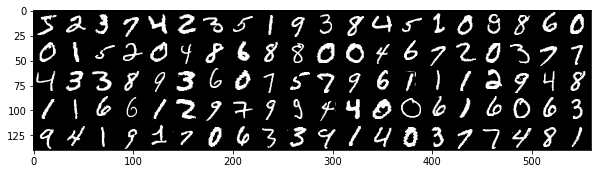

In [4]:
flattened_images = image_palette(X_train, 100)
plt.figure(figsize=(10,20))
plt.imshow(flattened_images);

## Train the RBM
**Exercise** What is the effect of the different parameters: **n_components** and **n_iter**. These parameters are, respectively, the number of components, and the number of iterations. <br/>
Evaluate the performance visually in the next code cell.


In [5]:
rbm = BernoulliRBM(n_components=100, learning_rate=0.01, random_state=0, n_iter=20, verbose=False)
rbm.fit(X_train)

BernoulliRBM(batch_size=10, learning_rate=0.01, n_components=100, n_iter=20,
             random_state=0, verbose=False)

## Sample the trained RBM and show the result
The gibbs_steps variable determines how many Gibbs sampling steps will be performed for each test image i.e. with the test images as initialization. <br/>
**Exercise** Try different values and observe the result. Can you explain the result? <br/>
Compare the result with the original test images, shown one cell lower.


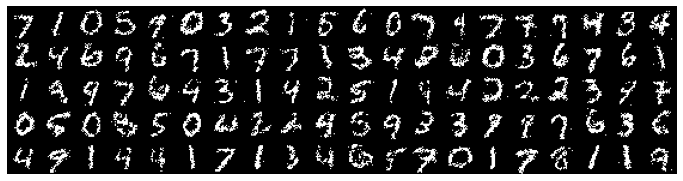

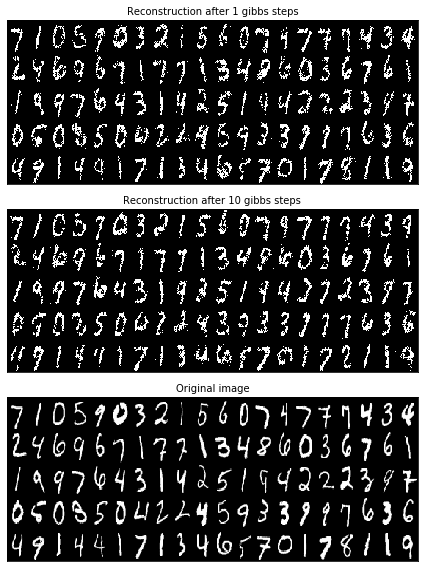

In [102]:
title_size = 10
# 1 gib step
fig, axs = plt.subplots(3, figsize=(6,8))
gibbs_steps = 1
a = X_test.copy()
for i in range(a.shape[0]):
  for j in range(gibbs_steps):
    a[i] = rbm.gibbs(a[i])
axs[0].imshow(image_palette(a), aspect="auto")
axs[0].set_title('Reconstruction after 1 gibbs steps', size=title_size)
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[0].get_yticklabels(), visible=False)
axs[0].tick_params(axis='both', which='both', length=0)

# 10 gibbs steps
gibbs_steps = 10
a = X_test.copy()
for i in range(a.shape[0]):
  for j in range(gibbs_steps):
    a[i] = rbm.gibbs(a[i])
axs[1].imshow(image_palette(a),aspect="auto")
axs[1].set_title('Reconstruction after 10 gibbs steps',size=title_size)
axs[1].tick_params(axis='both', which='both', length=0)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[1].get_yticklabels(), visible=False)
axs[0].tick_params(axis='both', which='both', length=0)

# original image
axs[2].imshow(image_palette(X_test), aspect="auto")
axs[2].set_title('Original image',size=title_size)
axs[2].tick_params(axis='both', which='both', length=0)
plt.setp(axs[2].get_xticklabels(), visible=False)
plt.setp(axs[2].get_yticklabels(), visible=False)
plt.tight_layout()
plt.savefig("output/rbm/figure1.png")

## Reconstruction of unseen images
In this cell, we will remove pixel rows from certain images. Using the recently trained RBM, we will then try to reconstruct the original images.  <br/>
The following variables control this process: <br/>


*   **reconstruction_gibbs_steps**: The number of gibbs steps used to reconstruct the image.
*   **start_test_index**: The first index of the test set to use.
*   **nr**: the number of images starting from **start_test_index** to reconstruct.
*   **start_row_to_remove**:  The index of the first row that should be removed.
*   **end_row_to_remove**: The index up to which the rows should be removed.

**Exercise** Adjust these variables and observe the result of the reconstruction in the shown image.
What is the role of the previously seen RBM hyperparameters on the reconstruction? <br/>
How many rows can you remove such that reconstruction is still possible? <br/>
In the next code cell, the removed rows will be replaced by the reconstructed rows.




In [22]:
store_results = {}

start_positions = [6,10,14,16]
rows_removed = [2,4,8,10]

reconstruction_gibbs_steps = 20
start_test_index = 0
nr = 1
index = 0
for s in start_positions:
    for r in rows_removed:
      start_row_to_remove = s
      end_row_to_remove = s + r
      to_reconstruct = X_test[start_test_index:start_test_index + nr].reshape((-1,28,28))
      to_reconstruct = remove_rows(to_reconstruct, start_row_to_remove, end_row_to_remove)
      reconstructed = np.zeros(to_reconstruct.shape)
      for i in range(nr):
        reconstructed[i] = rbm_gibbs_sample_image(rbm, to_reconstruct[i], reconstruction_gibbs_steps)
      combined_images = np.concatenate((to_reconstruct,reconstructed), axis=1)
      store_results[index] = combined_images
      index += 1

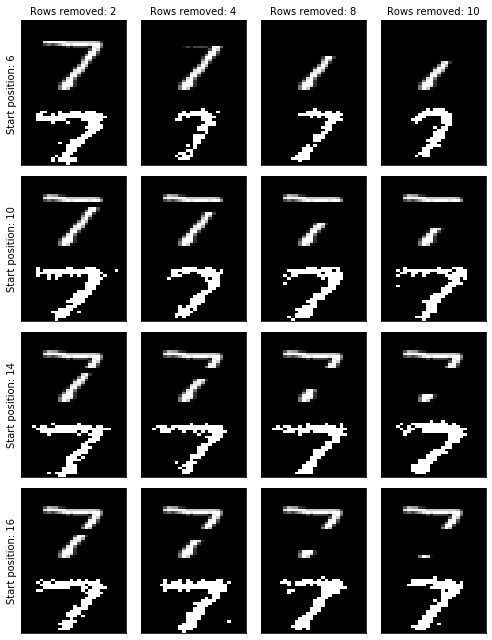

In [103]:
fig, axes = plt.subplots(4, 4, figsize=(7,9))
i = 0
for key, value in store_results.items():
    axes.flatten()[i].imshow(value[0], aspect='auto')
    plt.setp(axes.flatten()[i].get_xticklabels(), visible=False)
    plt.setp(axes.flatten()[i].get_yticklabels(), visible=False)
    axes.flatten()[i].tick_params(axis='both', which='both', length=0)
    i += 1
#plt.subplots_adjust(hspace=.2, wspace=-.1)

axes.flatten()[0].set_title('Rows removed: 2', size=title_size)
axes.flatten()[1].set_title('Rows removed: 4', size=title_size)
axes.flatten()[2].set_title('Rows removed: 8', size=title_size)
axes.flatten()[3].set_title('Rows removed: 10', size=title_size)

axes.flatten()[0].set_ylabel('Start position: 6', size=title_size)
axes.flatten()[4].set_ylabel('Start position: 10', size=title_size)
axes.flatten()[8].set_ylabel('Start position: 14', size=title_size)
axes.flatten()[12].set_ylabel('Start position: 16', size=title_size)

plt.tight_layout()
plt.savefig("output/rbm/figure2.png")

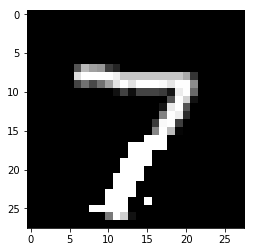

In [65]:
start_row_to_remove
end_row_to_remove
to_reconstruct[:,start_row_to_remove:end_row_to_remove] = reconstructed[:,start_row_to_remove:end_row_to_remove]
fig = plt.figure()
for i in range(nr): 
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(to_reconstruct[i])

plt.show()

## Component visualisation
In the final cell, the components (weights of each neuron) of the RBM are shown.<br/> 
Observing these components (think back to CNNs) may offer insights into the trained model.

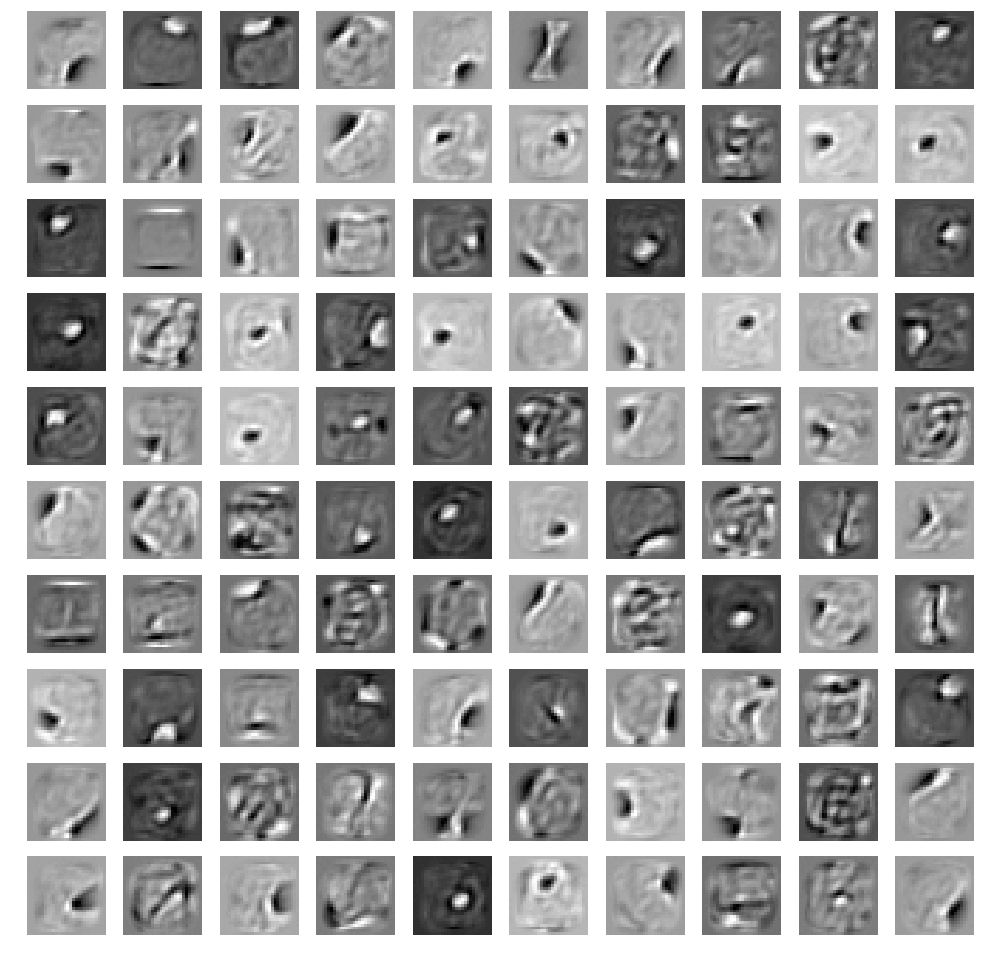

In [98]:
plt.figure(figsize=(17, 17))
nr_components = rbm.components_.shape[0]
for i in range(nr_components):
    c = rbm.components_[i]
    plt.subplot(10, np.ceil(nr_components/10), i + 1)
    plt.imshow(c.reshape((28, 28)), cmap = "gray", interpolation='nearest')
    plt.axis('off')
    
#plt.suptitle('Components extracted by the RBM', y=.93, size=30)
# plt.tight_layout();
plt.savefig("output/dbm/figure1.png", bbox_extra_artists=[my_suptitle])